In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
from tqdm import tqdm_notebook as tqdm
from skimage.transform import rescale, resize, downscale_local_mean
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/cimalab/thyroid/'

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook as tqdm
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np

#path to google drive folder
simp_path = '/content/drive/My Drive'
train_path = '/content/drive/My Drive/cimalab/train.csv'
validation_path = '/content/drive/My Drive/cimalab/validation.csv'
test_path = '/content/drive/My Drive/cimalab/test.csv'

#read csv
import pandas as pd
train = pd.read_csv(train_path)
validation = pd.read_csv(validation_path)
test = pd.read_csv(test_path)

#Reformatting dataframe
def reformat(dataframe):
  dataframe['filename'] = dataframe.filename.str[1:]
  dataframe['filename'] = simp_path + dataframe.filename
  file_paths = dataframe.filename.tolist()
  
  # creating a width and heigh dataframe
  # the intial dataframe the we created had coordinates for top-left and bottom-right
  dataframe['w'] = dataframe.x2 - dataframe.x1
  dataframe['h'] = dataframe.y2 - dataframe.y1
  return dataframe

train = reformat(train)
validation = reformat(validation)
test = reformat(test)
  
## function to resize input and output
## dataframe must be a pandas dataframe
def get_data(dataframe):
  img_path = dataframe.filename.tolist()
  coor = dataframe.drop(['filename','image_id','Unnamed: 0'], axis=1).values
  
  im_width = 128
  im_height = 128

  X = np.zeros((len(img_path), im_height, im_width, 3), dtype=np.float64)
  y = np.zeros((len(img_path), im_height, im_width, 3), dtype=np.float64)
  print('Getting and resizing images ... ')
  
## This loop transforms the coordinates by the same factor that the image
## is resized, so the coordinates are still accurate
  for n,f in tqdm(enumerate(img_path), total=len(img_path[:])):

    img = load_img(f)
    x_img = img_to_array(img)
    x_img = np.array(x_img,dtype=np.float64)

    ## (height,width) for numpy array
    ## x2 = column[2], y2 = [3]

    h = x_img.shape[0]
    w = x_img.shape[1]
    target_h = 128
    target_w = 128
    
    h_factor = h/target_h
    w_factor = w/target_w

    ## coor[n][0] == x1
    ## coor[n][1] == y1
    ## coor[n][2] == x2
    ## coor[n][3] == y2
    ## coor[n][4] == width
    ## coor[n][5] == height
    
    old_h = coor[n][5]
    old_w = coor[n][4]

    bounding_h = old_h * h_factor
    bounding_w = old_w * w_factor

    coor[n][5] = bounding_h
    coor[n][4] = bounding_w

    coor[n][2] = coor[n][0] + coor[n][4]
    coor[n][3] = coor[n][1] + coor[n][5]


    x_img = resize(x_img, (im_height, im_width, 1), preserve_range=True)
    X[n, ...,0] = x_img.squeeze()/255.

  return X, coor

train_X, train_coor = get_data(train)
valid_X, valid_coor = get_data(validation)
test_X, test_coor = get_data(test)

# Uncomment for model to ouput w,h instead of x2,y2
# train_coor = train_coor[:,[0,1,4,5]]
# valid_coor = valid_coor[:,[0,1,4,5]]
# test_coor  = test_coor[:,[0,1,4,5]]

# First four columns
train_coor = train_coor[:,[0,1,2,3]]
valid_coor = valid_coor[:,[0,1,2,3]]
test_coor  = test_coor[:,[0,1,2,3]]

In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers  import Dropout, Flatten, Dense
from keras.applications import xception
from keras.models  import Sequential
from keras import optimizers


conv_base = xception.Xception(
                     weights      = 'imagenet',
                     include_top  = False,
                     input_shape  = (128, 128, 3))

conv_base.trainable = True


xception_model = Sequential()
xception_model.add(conv_base)
xception_model.add(Flatten())
xception_model.add(Dropout(0.5))                      # Does a pre-trained model need a dropout?
xception_model.add(Dense(256, activation = 'linear')) # Set to linear for regression approach
xception_model.add(Dense(4, activation   = 'linear')) ## sigmoid

best_model = ModelCheckpoint("./xception/trial_2_xception.h5", monitor='val_loss', verbose=0, save_best_only=True)
xception_model.summary()
xception_model.compile(loss      = 'mean_squared_error',
                       optimizer = optimizers.Adam(),
                       metrics   = ['mse'])
progress = xception_model.fit(x=train_X, y=train_coor, epochs=20, verbose=1, batch_size = 32, validation_data = (valid_X, valid_coor))

In [0]:
acc      = progress.history['mean_squared_error']
val_acc  = progress.history['val_mean_squared_error']
loss     = progress.history['loss']
val_loss = progress.history['val_loss']

epochs   = range(len(acc))

plt.plot  (epochs, acc, 'bo',    label = 'Training')
plt.plot  (epochs, val_acc, 'b', label = 'Validation')
plt.title ('Training and validation MSE')
plt.legend()

plt.figure()

plt.plot  (epochs, loss, 'bo', label='Training')
plt.plot  (epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss')
plt.legend()

plt.show  ()

In [0]:
## Evaluate test predictions with IoU scores
## Retrived formula from here :  https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles
predict_ = xception_model.predict(x=test_X, batch_size=32, verbose=1)
predict_ = pd.DataFrame(predict_)

## Just renaming the cxolumns
predict_.rename(index=str, inplace = True,
              columns={0: "pred_x1", 1: "pred_y1",
                       2: "pred_x2", 3: "pred_y2"})
predict_['px2'] = predict_.pred_x1 + predict_.pred_x2
actual = pd.DataFrame(test_coor)
actual.rename(index=str, inplace = True,
              columns={0: "act_x1", 1: "act_y1",
                       2: "act_x2", 3: "act_y2"})
# Combining the actual values and the prediction values into one dataframe
framer = pd.concat([actual.reset_index(drop=True),predict_.reset_index(drop=True)], axis=1)

# Taking minimum value for x2 values
min_x2 = framer[['pred_x2','act_x2']].min(axis=1)

# Taking maximum for x1 values
max_x1 = framer[['pred_x1','act_x1']].max(axis=1)

# Taking minimum value for y2 values
min_y2 = framer[['pred_y2','act_y2']].min(axis=1)

# Taking minimum value for x2 values
max_y1 = framer[['pred_y1','act_y1']].max(axis=1)

dx = min_x2 - max_x1
dy = min_y2 - max_y1

width = framer['act_x2'] - framer['act_x1']
height = framer['act_y2'] - framer['act_y1']
w_pred = framer['pred_x2'] - framer['pred_x1']
h_pred = framer['pred_y2'] - framer['pred_y1']
overlap_area = dx*dy
true_area = (width*height)+(w_pred*h_pred)-(overlap_area)

framer['pct_overlap'] = (overlap_area/true_area)
framer.pct_overlap.mean()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[Text(0, 0.5, 'Distribution Density'), Text(0.5, 0, 'IoU Score')]

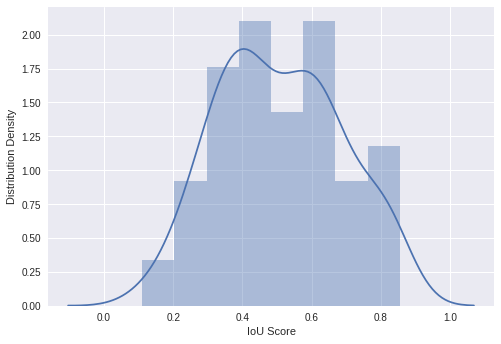

In [53]:
import seaborn as sns

ax = sns.distplot(framer.pct_overlap)
ax.set(xlabel='IoU Score', ylabel='Distribution Density')